In [ ]:
import modules

from collections import Counter

import cellpylib as cpl
import numpy as np
import pandas as pd

import pickle
import sys

import random

# Packages for plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
import ast


In [ ]:
sys.setrecursionlimit(10000)

In [ ]:
p = np.linspace(0.0, 0.9, 50)
L = 100
T = int(L / 2)
n = 20
p_slowdown = 0.3
v_max = 3

total_flows_per_density = dict()
average_flows_per_density = dict()

for density in p:
    lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, return_evolutions=True)
    

    total_flows = [modules.calculate_flow_nasch(evolution) for evolution in evolutions]
    average_flows = [flow / float(T) for flow in total_flows]
    
    total_flows_per_density[density] = total_flows
    average_flows_per_density[density] = average_flows

# Find critical point: the density for which the total flow average is maximum
mean_total_flow_per_density = {density: np.mean(flows) for density, flows in total_flows_per_density.items()}
critical_density = max(mean_total_flow_per_density, key=mean_total_flow_per_density.get)
print(f"Critical density: {critical_density}")

# plot total flow as a function of densities
plt.figure(figsize=(12,6))
plt.title(f'Total flow as a function of densities, p_slowdown = {p_slowdown}, v_max = {v_max}')
plt.plot(total_flows_per_density.keys(), total_flows_per_density.values(), 'o')
plt.plot(total_flows_per_density.keys(), [np.mean(flows) for flows in total_flows_per_density.values()], '--')

# Add a vertical line at the critical density
plt.axvline(x=critical_density, color='red', linestyle='--')

plt.xlabel('Initial Density')
plt.ylabel('Total flow')
plt.show()

In [ ]:
p_values = np.linspace(0.0, 1, 30)
L = 10
T = int(L / 2)
n = 1
p_slowdown_values = np.linspace(0.0, 1, 30)
v_max_values = [x for x in range(1, 6)]
repetitions = 1

output_df = modules.find_critical_dataframe_nasch(p_slowdown_values, v_max_values, p_values, L, T, n, repetitions=repetitions)

# Save the output to a csv file
output_df.to_csv(f'Results\\critical_densities_nasch_n={n}_L={L}_T={T}_#p={len(p_values)}_reps={repetitions}.csv', index=False)

# Plot the output per v_max
for v_max in v_max_values:
    df = output_df[output_df[f'v_max'] == v_max]
    x = list(df['p_slowdown'])
    y = list(df['critical_density']) # multiple values per x
    y_means = [np.mean(l) for l in y]
    plt.figure(figsize=(12,6))
    plt.title(f'Critical density as a function of slowdown probability for v_max={v_max}')
    plt.plot(x, y, 'o', color='blue')
    plt.plot(x, y_means, '-', color='red')
    plt.xlabel('Slowdown probability')
    plt.ylabel('Critical density')
    plt.show()

In [ ]:
def density_evolution_nasch (evolution):
    """
    Function to calculate the density evolution of the NaSch model. The density is defined as the
    amount of cars in total. This is calculated by summing the total amount of cars.
    Input: 
    - evolution (list): List containing the evolution of the model for each timestep.
    Output:
    - density_evolution (list): List containing the density evolution of the model for each timestep.
    """
    location_evolution = [[x[0] for x in line] for line in evolution]
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]
    return density_evolution


In [ ]:
# Test non-dynamic model

initial_density = 0.4
L = 10
T = 5
n = 1

# NaSch parameters
p_slowdown = 0.1
v_max = 3

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(initial_density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False)

# Visualize the evolution
evolution = evolutions[0]

location_evolution = [[x[0] for x in line] for line in evolution]
speed_evolution = [[x[1] for x in line] for line in evolution]

flow = modules.calculate_flow_nasch(evolution)
print(f"Flow: {flow}")

# Create your own colormap from hexcode
colors = ["#ffffff", "#d8eeac"]

colormap = LinearSegmentedColormap.from_list("my_colormap", colors)

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
fig.suptitle(f"Evolution of the simple non-dynamic model \nρ = {initial_density}, p_slowdown = {p_slowdown}, v_max = {v_max}", fontsize=18)
cpl.plot(location_evolution, colormap=colormap,
         xlabel='Location', ylabel='Time')

density_test = density_evolution_nasch(evolution)
plt.plot(density_test)



In [ ]:
# Test dynamic model (with dynamics actually shown)
initial_density = 0.4
L = 10
T = 5
n = 1

# NaSch parameters
p_slowdown = 0.1
v_max = 3

# Dynamic parameters
neighbourhood_size = 3
entry_chance = 0.05
exit_chance = 0.05

while True:

    lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(initial_density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                        return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                        entry_chance=entry_chance, exit_chance=exit_chance)

    # Visualize the evolution
    evolution = evolutions[0]

    location_evolution = [[x[0] for x in line] for line in evolution]
    speed_evolution = [[x[1] for x in line] for line in evolution]

    flow = modules.calculate_flow_nasch(evolution)


    density_test = density_evolution_nasch(evolution)

    # Check if density goes up and down, and first density = initial_density
    up = False
    down = False
    
    for i in range(1, len(density_test)):
        if density_test[i] > density_test[i-1]:
            up = True
        if density_test[i] < density_test[i-1]:
            down = True
    
    if up and down and density_test[0] == initial_density:
        break

# Create your own colormap from hexcode

colors = ["#ffffff", "#d8eeac"]

colormap = LinearSegmentedColormap.from_list("my_colormap", colors)

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
# fig.suptitle(f"Evolution of dynamic model \ninitial ρ = {initial_density}, p_slowdown = {p_slowdown}, v_max = {v_max},\nentry_chance = {entry_chance}, exit_chance = {exit_chance}, neighbourhood_size = {neighbourhood_size}", 
            #  fontsize=18)
cpl.plot(location_evolution, colormap=colormap,
         xlabel='Location', ylabel='Time')

print(f"Flow: {flow}")
plt.plot(density_test)

In [ ]:
modules.test_new_jam_finder()

# Jam Size Distribution NaSch without dynamics

In [ ]:
sys.setrecursionlimit(10000)

#Critical densities (5) from data file for p_slowdown and vmax fixed 
#0.4482758620689655,3,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2413793103448276, 0.22068965517241382, 0.2, 0.2]

p = 0.22068965517241382
L = 300
T = int(L/2)
n = 1

# NaSch parameters
p_slowdown = 0.4482758620689655
v_max = 3

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01
dynamic_model=False
return_evolutions=True

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown,return_evolutions=return_evolutions, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)




#To save data in file for plot
#file = open('Results/loglog_jam_nondynamic_critical.txt', 'wb')
#pickle.dump(jam_size_counter, file)
#file.close()

## Visualize Jam Size distribution in log log plot and check for powerlaw (no dynamics)

In [ ]:
file = open('Results/loglog_jam_nondynamic_critical.txt', 'rb')
jam_size_counter = pickle.load(file)

result, exponent = modules.analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
 

plt.figure(figsize=(10,8))
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='#356058', markersize=8)

plt.legend(['Jam size distribution'])
plt.grid()
plt.title(f'$\\rho$={p}, v_max={v_max}, p_slowdown={p_slowdown},$\\tau$={exponent} ', fontsize=10)
plt.xlabel('Jam size', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.suptitle(f'Jam size distribution for L={L} in non dynamical model', fontsize=25)
plt.show()

# Jam Size Distribution NaSch With Dynamics 

In [ ]:
p = 0.2
L = 300
T = int(L/2)
n = 1

# NaSch parameters
p_slowdown = 0.4
v_max = 3

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01

dynamic_model = True
return_evolutions=True

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown,return_evolutions=return_evolutions, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


#To save data in file for plot
#file = open('Results/loglog_jam_dynamic_critical.txt', 'wb')
#pickle.dump(jam_size_counter, file)
#file.close()

## Visualize Jam Size distribution in log log plot and check for powerlaw (dynamics)

In [ ]:
file = open('Results/loglog_jam_dynamic_critical.txt', 'rb')
jam_size_counter = pickle.load(file)

result, exponent = modules.analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)

plt.figure(figsize=(10,8))
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='#356058', markersize=8)
plt.legend(['Jam size distribution'])
plt.grid()
plt.title(f'$\\rho$={p}, v_max={v_max}, p_slowdown={p_slowdown},$\\tau$={round(exponent,2)}', fontsize=10)
plt.xlabel('Jam size', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.suptitle(f'Jam size distributions for L={L} in dynamical model', fontsize=25)
plt.show()

# Jam Size Distribution CA (p_slowdown=0, vmax=1)


In [ ]:
sys.setrecursionlimit(10000)

p = 0.22068965517241382
L = 300
T = int(L/2)
n = 1

# NaSch parameters
p_slowdown = 0 
v_max = 1 

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01

dynamic_model=False

return_evolutions=True

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=return_evolutions, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


#To save data in file for plot
#file = open('Results/loglog_jam_CA_critical.txt', 'wb')
#pickle.dump(jam_size_counter, file)
#file.close()


## Visualize Jam Size distribution in log log plot and check for powerlaw (CA)

In [ ]:
file = open('Results/loglog_jam_CA_critical.txt', 'rb')
jam_size_counter = pickle.load(file)

#check for powerlaw and make loglog plot for visualisation
result, exponent = modules.analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)

plt.figure(figsize=(10,8))
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='#356058', markersize=8)

#line to plot the critical exponent line in the plot 
#plt.loglog(range(1, int(max(jam_size_counter.keys()))), power(range(1, int(max(jam_size_counter.keys()))), exponent), '--')
plt.legend(['Jam size distribution'])
plt.grid()
plt.title(f'$\\rho$={p}, v_max={v_max}, p_slowdown={p_slowdown},$\\tau$={exponent} ', fontsize=10)
plt.xlabel('Jam size', fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.suptitle(f'Jam size distribution for L={L} in CA 184', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Analyze powerlaw of the dynamic exponent of the NaSch traffic flow

In [ ]:

L = 100
T = int(L/2)
n = 1

# NaSch parameters
p_slowdown = 0.3157894736842105
v_max = 3

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.1
exit_chance = 0.1
dynamic_model=True
return_evolutions=True

p_value = np.linspace(0.1, 0.9, 9)

for p in p_value: 
    lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown,return_evolutions=return_evolutions, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size,
                                                                        entry_chance=entry_chance, exit_chance=exit_chance)

    result_jam_test = modules.analyze_powerlaw_distribution(list(jam_size_counter.elements()))
    
    print ("for initial density:", p) 
    print(result_jam_test) #print result of power law test
    

# Relationship between critical exponent and initial density for dynamical model

In [ ]:

sys.setrecursionlimit(50000)

# A power-law distribution for a given initial density
def analyze_critical_exponent_for_density(p, L, T, n_repetitions, v_max, p_slowdown, triangular, dynamic_model, neighbourhood_size, entry_chance, exit_chance):
    """Function that saves the critical exponent for a initial density."""

    # Nasch model
    lifespan_counter, jam_counter = modules.run_model_stochastic(p, L, T, n_repetitions, v_max, p_slowdown, triangular, return_evolutions=False, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size, entry_chance=entry_chance, exit_chance=exit_chance)
    
    # Previous defined analyze_powerlaw_distribution function 
    result, exponent = modules.analyze_powerlaw_distribution(list(jam_counter.elements()))
    
    return p, exponent

# Parameters
L = 100
T = int(L/2)
n_repetitions = 1
v_max = 3
p_slowdown = 0.8
triangular = False
dynamic_model = True
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01

# Initial Densities 
initial_densities = np.linspace(0.1, 0.85, 100)

# Collect Results
results = [analyze_critical_exponent_for_density(p, L, T, n_repetitions, v_max, p_slowdown, triangular, dynamic_model, neighbourhood_size, entry_chance, exit_chance) for p in initial_densities]

# Unpack Results
densities, exponents = zip(*results)

#save plot
#file = open('Results/densities_density_dynamic_pslow08.txt', 'wb')
#pickle.dump(results, file)
#file.close()

# pslowdown = 0.8

In [ ]:
# Visualize Results
file = open('Results/densities_density_dynamic_pslow08.txt', 'rb')
results = pickle.load(file)

# Unpack Results
densities, exponents = zip(*results)

# Perform linear regression
fit_params = np.polyfit(densities, exponents, 1)
fit_line = np.polyval(fit_params, densities)

plt.figure(figsize=(10,8))
plt.grid()
plt.plot(densities, exponents, 'o', color='#356058',linewidth=3,label='Critical Exponent')
plt.plot(densities, fit_line, '--', color='darkorange', linewidth=3, label='Linear Fit')
plt.xlabel('Initial Density ($\\rho$)', fontsize=20)
plt.ylabel('Critical Exponent ($\\tau$)', fontsize=20)
plt.title(f'vmax={v_max}, p_slowdown={p_slowdown}', fontsize=20)
plt.suptitle(f'Critical Exponent vs. Initial Density for L={L} in dynamical model', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(1.5,2)
plt.legend()
plt.show()


# pslowdown = 0.2

In [ ]:
# Visualize Results
file = open('Results/densities_density_dynamic_pslow02.txt', 'rb')
results = pickle.load(file)

# Unpack Results
densities, exponents = zip(*results)

plt.figure(figsize=(10,8))
plt.grid()
plt.plot(densities, exponents, 'o', color='#356058',linewidth=3,label='Critical Exponent')
plt.xlabel('Initial Density ($\\rho$)', fontsize=20)
plt.ylabel('Critical Exponent ($\\tau$)', fontsize=20)
plt.title(f'vmax={3}, p_slowdown={0.2}', fontsize=20)
plt.suptitle(f'Critical Exponent vs. Initial Density for L={L} in dynamical model', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,5)
plt.legend()
plt.show()

# CRITICAL DENSITY PLOT

In [ ]:
filepath = 'Results/critical_densities_nasch_n=10_L=200_T=100_#p=30_reps=10.csv'
df = pd.read_csv(filepath)

# Load in values
x_values = df['p_slowdown'].values
y_values = df['v_max'].values
z_values = [np.mean(ast.literal_eval(string)) for string in df['critical_density'].values]


# Create grid to later put Z values on
xi, yi = np.linspace(min(x_values), max(x_values), 100), np.linspace(min(y_values), max(y_values), 100)

# Put actual datapoints on grid
X, Y = np.meshgrid(xi, yi)

# Put z_value data on the grid and interpolate 
Z = griddata((x_values, y_values), z_values, (X, Y), method='cubic')

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# Set labels, title and ticks
ax.set_xlabel(r'P(slow down)', labelpad=15, fontsize=20)
ax.set_ylabel(r'$v_{max}$', labelpad=15, fontsize=24)
ax.set_zlabel(r'$\rho_{critical}$', labelpad=18, fontsize=24)

ax.tick_params(axis='x', which='both', labelsize=15)
ax.tick_params(axis='y', which='both', labelsize=15)
ax.tick_params(axis='z', which='both', labelsize=15, pad=10)

plt.title(r'            $\rho_{critical}$ for different values for $v_{max}$ and P(slow down)', fontsize=25)

# Add colorbar
bar = fig.colorbar(surf, ax=ax, shrink=0.5)
bar.ax.set_title(r'$\bar{\rho}$', fontsize=20)
bar.ax.tick_params(axis='y', which='both', labelsize=15)


# Set view
ax.view_init(elev=45, azim=45) 
ax.dist = 12
plt.savefig('Plots_presentation/critical_density_3D.png')

# MOVEMENT TOWARDS CRTIICAL DENSITY

In [ ]:
L = 30
n = 10
v_max = 5
p_slowdown = 0.3
neighbourhood_size = 10
entry_chance = 0.1
exit_chance = 0.1
dynamic_model=True

densities_dynamic = []
for p_idx, p in enumerate(np.linspace(0.3, 0.9, 120)):
    density_dynamic = modules.find_density(L, p, n, v_max, p_slowdown, dynamic_model, neighbourhood_size, entry_chance, exit_chance)
    densities_dynamic.append(density_dynamic)

# file = open('Results/densities_dynamic.txt', 'wb')
# pickle.dump(densities_dynamic, file)
# file.close()

In [ ]:
# file = open('Results/densities_dynamic.txt', 'rb')
# densities_dynamic = pickle.load(file)

plt.figure(figsize=(10,12))

for density in densities_dynamic:
    plt.plot(density, '#356058', alpha=0.3)


plt.plot([-100, 300], [np.mean(densities_dynamic), np.mean(densities_dynamic)], color='darkorange', linewidth=4)
plt.xlim(0,30)
plt.ylim(0.3,0.9)
plt.grid(alpha=0.4)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Density', fontsize=25)
plt.yticks([0.3, 0.9, np.mean(densities_dynamic)], [r'$0.3$', r'$0.9$', r'$\bar{\rho}$'], fontsize=20)
plt.xticks(fontsize=20)
plt.title(r'Evolution of $\rho$ of cars over time', fontsize=30)

# DENSITY VERSUS EXIT AND ENTRY CHANCE

In [67]:
L = 300
n = 10
v_max = 5
p_slowdown = 0.3
neighbourhood_size = 10
entry_chance = 0.1
dynamic_model=True

final_density_dict = {}

for ratio_idx, ratio in enumerate(np.linspace(0.1, 4, 40)):
    final_density_column = []  # List to store values for the current ratio
    for p_idx, p in enumerate(np.linspace(0.3, 0.9, 30)):
        exit_chance = ratio * entry_chance
        densities = modules.find_density(L, p, n, v_max, p_slowdown, dynamic_model, neighbourhood_size, entry_chance, exit_chance)
        density_mean = np.mean(densities[L:])
        final_density_column.append(density_mean)

    # Store the entire list of values for the current ratio
    final_density_dict[ratio] = final_density_column

file = open('Results/final_density_dict.txt', 'wb')
pickle.dump(final_density_dict, file)
file.close()


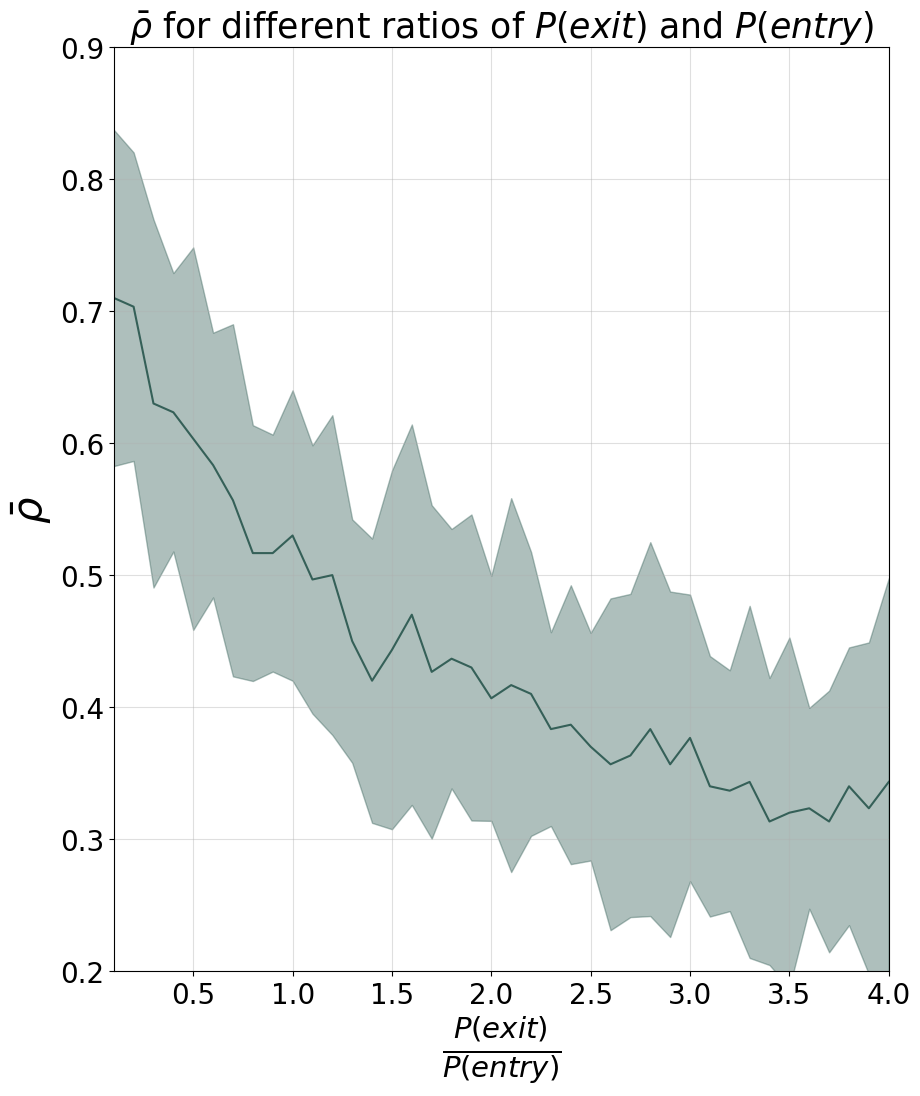

In [66]:
file = open('Results/final_density_dict.txt', 'rb')
final_density_dict = pickle.load(file)

ratios = np.linspace(0.1, 4, 40)

means = [np.mean(final_density_dict[ratio]) for ratio in ratios]
std_devs = [np.std(final_density_dict[ratio]) for ratio in ratios]

plt.figure(figsize=(10,12))

plt.plot(ratios, means, label='Final Density', color='#356058')
plt.fill_between(ratios, np.subtract(means, std_devs), np.add(means, std_devs), alpha=0.4, color='#356058')
plt.plot([0,30], [np.mean(means), np.mean(means)], color='darkorange')

plt.xlim(0.1,4)
plt.ylim(0.2,0.9)
plt.grid(alpha=0.4)
plt.xlabel(r'$\frac{P(exit)}{P(entry)}$', fontsize=30)
plt.ylabel(r'$\bar{\rho}$', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title(r'$\bar{\rho}$ for different ratios of $P(exit)$ and $P(entry)$', fontsize=25)

plt.show()